# JPR 2017 E. coli replicates (MS2 versus MS3)

### Analysis performed by Phil Wilmarth

### 20190418

The data from the publication below was downloaded from [PRIDE](https://www.ebi.ac.uk/pride/archive/projects/PXD005486). One set of samples was an E. coli background with a few (13) spiked in human proteins. The amounts of the spike ins varied by channel in the 10-plex TMT labeling. The same sample was run with a more traditional MS2 reporter ion method, and the newer synchronous precursor scan MS3 method. The dataset does not lend itself to an analysis of accuracy and dynamic range, but we can see if the duty cycle or signal intensities are very different between the two ways of acquiring reporter ions signals. The E. coli background is also the same in all channels and can be used to check technical replicate reproducibility.

> D’Angelo, G., Chaerkady, R., Yu, W., Hizal, D.B., Hess, S., Zhao, W., Lekstrom, K., Guo, X., White, W.I., Roskos, L. and Bowen, M.A., 2017. Statistical models for the analysis of isobaric tags multiplexed quantitative proteomics. Journal of proteome research, 16(9), pp.3124-3136.

The data were generated on a Thermo Fusion using either a basic HCD MS2 method or the newer SPS MS3 method. Resolution was 60K for the scans containing the reporter ion signals in either method.
 
---

## Overview

Peptides and proteins were identified using Comet and the PAW pipeline. A wider 1.25 Da parent ion mass tolerance was used, TMT labels and alkylated cysteine were specified as static modifications, oxidation of methionine was specified as a variable modification, trypsin enzyme specificity was used, and a UniProt reference E. coli protein database was used (with addition of the 13 human protein sequences). Fragment ion tolerance was set to 0.02 Da with offset of 0.0 for MS2 mode data, and 1.0005 Da with offset of 0.40 for the MS3 mode data. Confident peptide identifications were obtained using accurate mass conditional score histograms, the target/decoy method, and the protein inference used basic parsimony principles. 

The PAW pipeline was used to infer proteins, perform homologous protein grouping, establish peptide uniqueness to the inferred proteins, and sum unique PSM reporter ions into protein intensity totals.

Results tables were filtered to remove common contaminants and the protein intensity tables were saved as tab-delimited text files for reading by the scripts below. Normalizations and statistical testing were performed using the Bioconductor package edgeR as detailed in the steps below. A [Jupyter notebook](https://jupyter.org/) with an R kernel was used to execute R commands and visualize the results. 

> Thompson, A., Schäfer, J., Kuhn, K., Kienle, S., Schwarz, J., Schmidt, G., Neumann, T. and Hamon, C., 2003. Tandem mass tags: a novel quantification strategy for comparative analysis of complex protein mixtures by MS/MS. Analytical chemistry, 75(8), pp.1895-1904.

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

## Previous analysis was done with MaxQuant

A [previous analysis](https://pwilmart.github.io/TMT_analysis_examples/MS2MS3_peptides_proteins.html) was done with MaxQuant (v 1.5.7.4) and looked at how the data at different levels (PSM, peptide and protein) behaved. We also had PSM identification numbers (1% FDR) that we can compare to the new PAW analysis.


|Mode|MS2 Scans|MQ PSMs|PAW PSMs|Gain|
|----|---------|-------|--------|----|
|MS2|192649|46591|59348|27%|
|MS3|144634|33475|44440|33%|

The numbers of MS2 scans acquired and identified for the SPS MS3 method was lower than for the MS2 method. There is a duty factor hit for the more complicated method. Comet/PAW again outperforms MaxQuant/Andromeda by a large margin.

## Load the necessary libraries here

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor


Attaching package: ‘psych’

The following objects are masked from ‘package:scales’:

    alpha, rescale

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



## Load the prepped TMT intensity data

In [2]:
# load the data and check the table
data_import <- read_tsv("JPR-2017_grouped-proteins_TMT.txt", skip = 4, guess_max = 2500)

# the "Filter" column flags contams and decoys
# the prepped table from pandas is sorted so these are the upper rows
data_all <- filter(data_import, is.na(Filter))
data_ms2 <- data_all %>% 
    select(-Accession) %>% 
    select(ends_with("_MS2")) %>%
    select(starts_with("TotInt_")) %>%
    select(-contains("_131C_"))
data_ms3 <- data_all %>% 
    select(-Accession) %>% 
    select(ends_with("_MS3")) %>%
    select(starts_with("TotInt_")) %>%
    select(-contains("_131C_"))

# save gene names for edgeR so we can double check that results line up
accessions <- data_all$Accession

# see how many rows in the table
nrow(data_ms2)
head(data_ms2)

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character(),
  Identical = col_character(),
  Similar = col_character(),
  OtherLoci = col_character(),
  Filter = col_character(),
  Coverage = col_character(),
  SeqLength = col_character(),
  MW = col_character(),
  Description = col_character()
)
See spec(...) for full column specifications.
Warning message:
“2295 parsing failures.
row col   expected     actual                                file
  1  -- 46 columns 73 columns 'JPR-2017_grouped-proteins_TMT.txt'
  2  -- 46 columns 73 columns 'JPR-2017_grouped-proteins_TMT.txt'
  3  -- 46 columns 73 columns 'JPR-2017_grouped-proteins_TMT.txt'
  4  -- 46 columns 73 columns 'JPR-2017_grouped-proteins_TMT.txt'
  5  -- 46 columns 73 columns 'JPR-2017_grouped-proteins_TMT.txt'
... ... .......... .......... ...................................
See problems(...) for more details.
”

[1] 2107

TotInt_126C_MS2,TotInt_127N_MS2,TotInt_127C_MS2,TotInt_128N_MS2,TotInt_128C_MS2,TotInt_129N_MS2,TotInt_129C_MS2,TotInt_130N_MS2,TotInt_130C_MS2,TotInt_131N_MS2
122166373,129744769,113941041,137507084,156076323,115001272,141956648,140538582,131524474,119903569
113776543,126049810,104250564,132811821,147843328,112343546,133409185,137281755,120248791,117151126
76605533,70021580,72050391,84663763,88427450,69489115,88728917,86510843,72588053,73611630
90932769,83309152,86740833,97568654,99575630,88252582,103361223,98549850,87867108,90194774
62499547,63603949,59346125,69541641,74435070,59642913,72548470,70160112,61685532,61364567
64595640,61330655,61168717,69997224,74485877,64924472,73468438,72830984,64843085,66233836


## EdgeR has TMM normalization and some useful data visualizations 

We need to load the data into an edgeR data structure, run TMM normalization, and then generate the cluster plot. A multi-dimensional scaling plot (similar to hierarchical clustering or PCA plots) is a good way to check the data. 

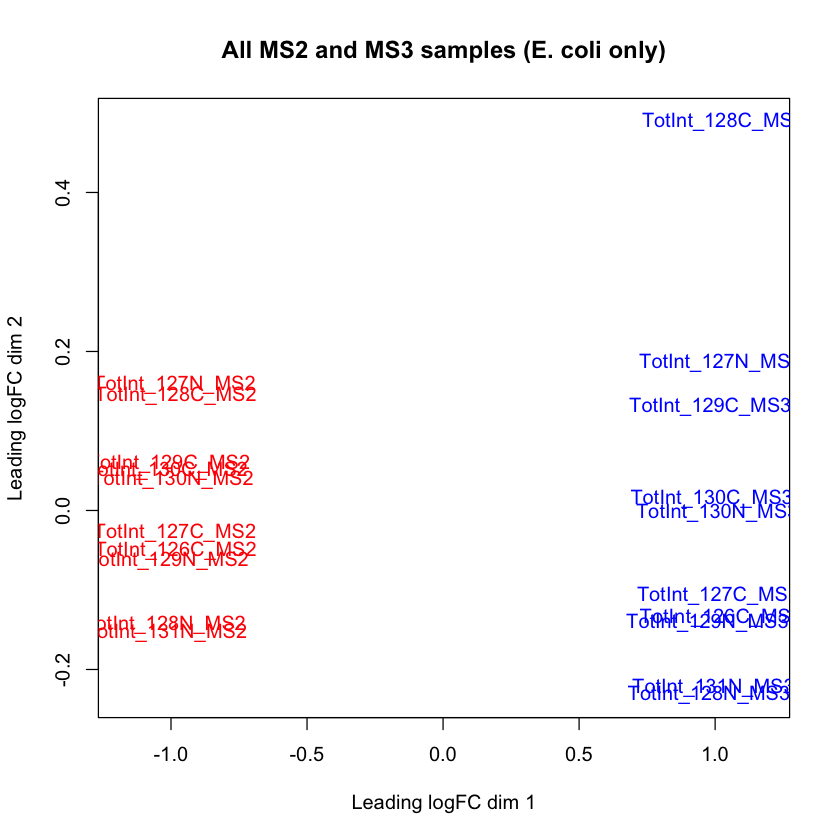

In [3]:
# get the biological sample data into a DGEList object
group = c(rep('MS2', 10), rep('MS3', 10))
y <- DGEList(counts = cbind(data_ms2, data_ms3), group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y <- calcNormFactors(y)

# set some colors by condition
colors = c(rep('red', 10), rep('blue', 10))

# check the clustering
plotMDS(y, col = colors, main = "All MS2 and MS3 samples (E. coli only)")

## Samples cluster by TMT acquisition mode

We have pretty clear separation by acquisition mode (reporter ions in MS2 scans or reporter ions in MS3 scans). There may be more variability in the MS3 data (more vertical spread) compared to the MS2 data. We could have some dynamic range compression in the MS2 data, or we could have some increased uncertainties in the MS3 data due to lower signals after the extra round of isolation. 

In [4]:
# see what the normalization factors look like
y$samples

,group,lib.size,norm.factors
TotInt_126C_MS2,MS2,3774271548,1.1614806
TotInt_127N_MS2,MS2,3975922576,1.1707087
TotInt_127C_MS2,MS2,3688931429,1.1700229
TotInt_128N_MS2,MS2,4262439022,1.1875028
TotInt_128C_MS2,MS2,4648505018,1.1737887
TotInt_129N_MS2,MS2,3827211525,1.2035729
TotInt_129C_MS2,MS2,4483870677,1.1818258
TotInt_130N_MS2,MS2,4419149782,1.1843564
TotInt_130C_MS2,MS2,4022375687,1.1977826
TotInt_131N_MS2,MS2,3942161231,1.1910234


## TMM normalization factors are in two clusters

The MS2 data have factors around 1.2 and the MS3 data have factors of 0.85.

## Compute the normalized intensities

EdgeR uses the normalization factors in its statistical modeling but does not output the normalized intensities. We have to compute the normalized intensities by hand below. 

Overall Factors (lib.size+TMM):
 TotInt_126C_MS2 -> 0.884794
 TotInt_127N_MS2 -> 0.833299
 TotInt_127C_MS2 -> 0.898654
 TotInt_128N_MS2 -> 0.766292
 TotInt_128C_MS2 -> 0.710860
 TotInt_129N_MS2 -> 0.842040
 TotInt_129C_MS2 -> 0.731949
 TotInt_130N_MS2 -> 0.741082
 TotInt_130C_MS2 -> 0.805057
 TotInt_131N_MS2 -> 0.826100
 TotInt_126C_MS3 -> 1.374529
 TotInt_127N_MS3 -> 1.290147
 TotInt_127C_MS3 -> 1.401262
 TotInt_128N_MS3 -> 1.213964
 TotInt_128C_MS3 -> 1.089566
 TotInt_129N_MS3 -> 1.375062
 TotInt_129C_MS3 -> 1.148705
 TotInt_130N_MS3 -> 1.157972
 TotInt_130C_MS3 -> 1.283974
 TotInt_131N_MS3 -> 1.297571


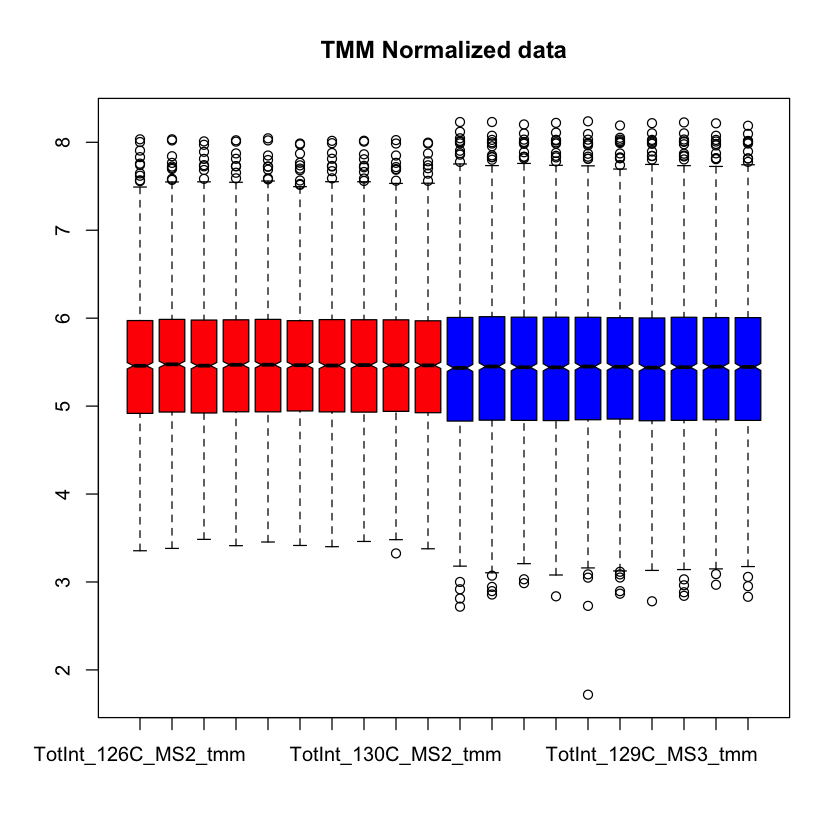

In [5]:
# ================== TMM normalization from DGEList object =====================

apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute grand total (library size) scalings
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size

    # the TMM factors are library adjustment factors (so divide by them)
    norm_facs <- lib_facs / y$samples$norm.factors
    cat("Overall Factors (lib.size+TMM):\n", sprintf("%-5s -> %f\n", 
                                                     colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}
# compute the normalized data as a new data frame
data_tmm <- apply_tmm_factors(y, colors)

## Check the normalizations with density plots 

Box plots for well normalized data should be similar in size and the medians should align with each other. There can be problems with the data that may not be apparent with boxplots (some data distortions can average out and not appear different with boxplots). Regardless, we should have boxplots with good median alignment. Good boxplot behavior is a necessary but not sufficient requirement of proper normalization. 

We will use ggplot2 for the density plots. We need tidy (long form) data for ggplot:

In [6]:
long_results <- gather(data_tmm, key = "sample", value = "intensity") %>%
  mutate(log_int = log10(intensity)) %>%
  extract(sample, into = 'group', ".*_(.*?)_", remove = FALSE)
head(long_results)

sample,group,intensity,log_int
TotInt_126C_MS2_tmm,MS2,108092103,8.033794
TotInt_126C_MS2_tmm,MS2,100668830,8.002895
TotInt_126C_MS2_tmm,MS2,67780134,7.831102
TotInt_126C_MS2_tmm,MS2,80456790,7.905563
TotInt_126C_MS2_tmm,MS2,55299239,7.742719
TotInt_126C_MS2_tmm,MS2,57153850,7.757045


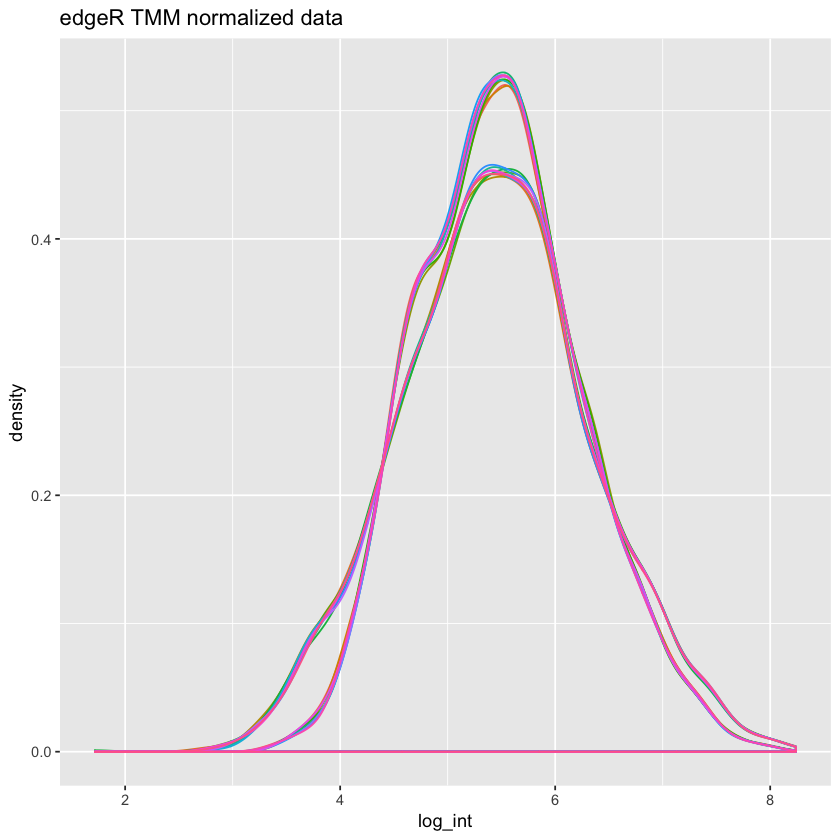

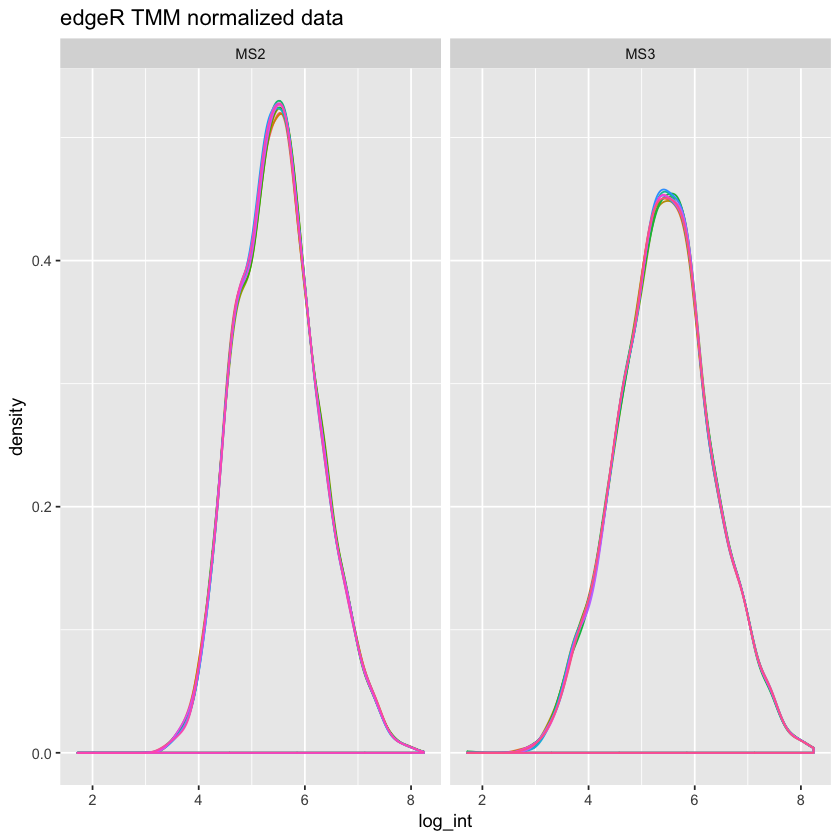

In [7]:
# plot density distributions
ggplot(long_results, aes(x = log_int, color = sample)) +
  geom_density() +
  guides(color = FALSE) +
  ggtitle("edgeR TMM normalized data")

# separate plots to see which is which
ggplot(long_results, aes(x = log_int, color = sample)) +
  geom_density() +
  facet_wrap(~ group) +
  guides(color = FALSE) +
  ggtitle("edgeR TMM normalized data")

## Each mode (MS2 or MS3) are very similar after normalization

Within acquisition mode, the distributions are very well aligned. The shapes of the distribution are a little different between modes.

## How reproducible are samples within acquisition mode?

The distributions of Coefficients of Variation (CVs) are another way to get an idea of how individual proteins are behaving. This seems to be an effective way to assess proper normalization in these experiments. We will compute CV distributions for each of the two acquisition modes.

In [8]:
# save column indexes for different conditions (indexes to data_raw frame)
# these make things easier (and reduce the chance for errors)
ms2 <- 1:10
ms3 <- 11:20

# create a CV computing function
CV <- function(df) {
    ave <- rowMeans(df)
    sd <- apply(df, 1, sd)
    cv <- 100 * sd / ave
}

# put CVs in data frames to simplify plots and summaries
cv_frame <- data.frame(ms2_raw = CV(data_ms2), ms2_tmm = CV(data_tmm[ms2]), 
                       ms3_raw = CV(data_ms3), ms3_tmm = CV(data_tmm[ms3]))


# see what the median CV values are
medians <- apply(cv_frame, 2, FUN = median)
print("Median CVs by mode, before/after  (%)")
round(medians, 1)

[1] "Median CVs by mode, before/after  (%)"


ms2_raw ms2_tmm ms3_raw ms3_tmm 
    9.7     5.3    10.6     6.5

## Use ggplot to explore the CV data

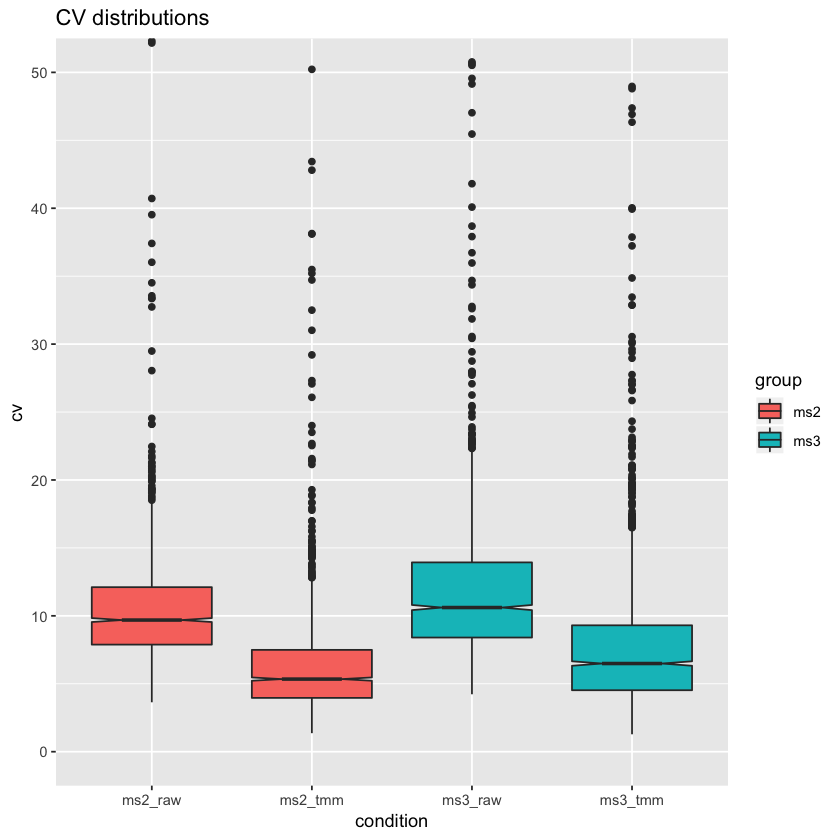

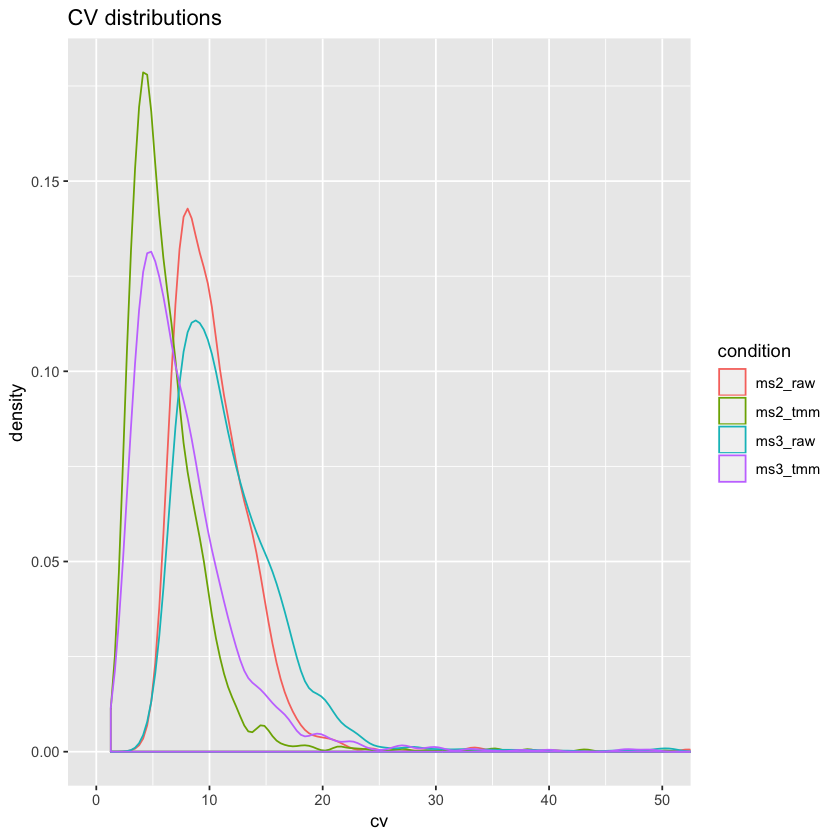

In [9]:
# see what the CV distibutions look like
# need long form for ggplot
long_cv <- gather(cv_frame, key = "condition", value = "cv") %>%
  extract(condition, into = 'group', "(.*?)_+", remove = FALSE)

# traditional boxplots
ggplot(long_cv, aes(x = condition, y = cv, fill = group)) +
  geom_boxplot(notch = TRUE) +
  coord_cartesian(ylim = c(0, 50)) +
  ggtitle("CV distributions")

# density plots
ggplot(long_cv, aes(x = cv, color = condition)) +
  geom_density() +
  coord_cartesian(xlim = c(0, 50)) +
  ggtitle("CV distributions")

## Data are improved by the normalizations

The CVs are much improved after TMM normalizations.  

## See what channel to channel similarity is like

We can randomly pick some channels from each acquisition mode and see how well they correlate with each other for the 2100 proteins.

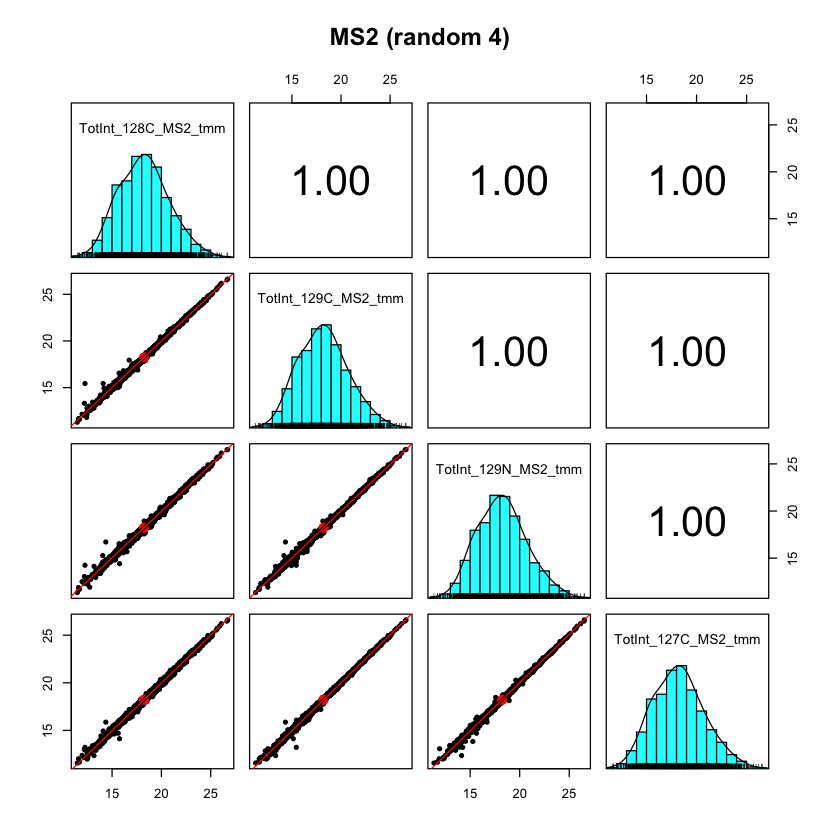

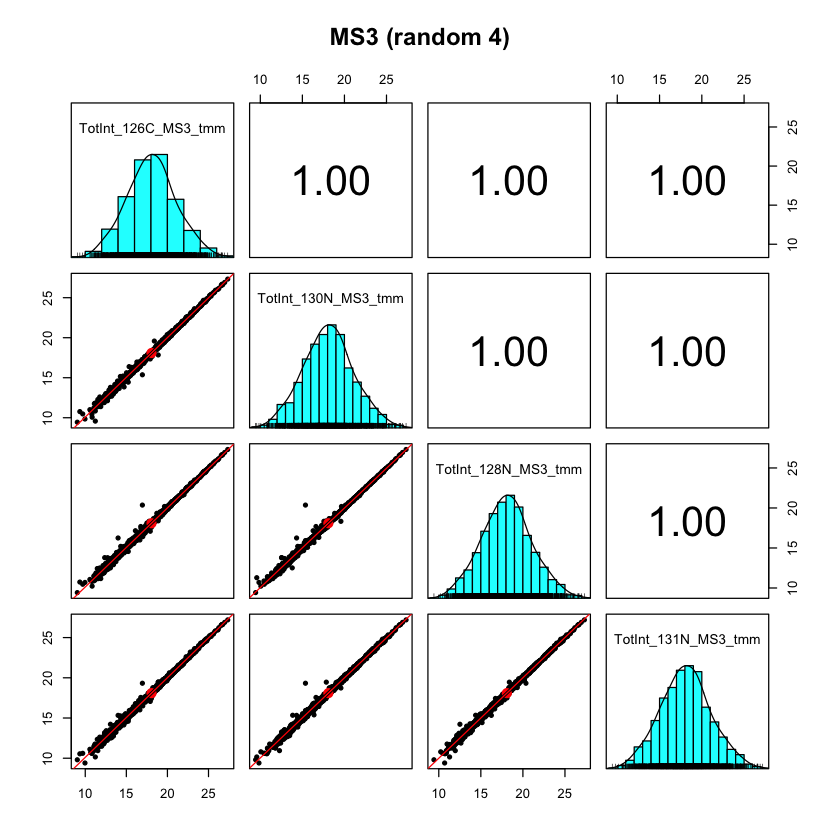

In [10]:
# multi-panel scatter plot grids
idx2 <- sample(1:10, 4)
idx3 <- sample(11:20, 4)
pairs.panels(log2(data_tmm[idx2]), lm = TRUE, main = "MS2 (random 4)")
pairs.panels(log2(data_tmm[idx3]), lm = TRUE, main = "MS3 (random 4)")

## The replicates are very similar to each other within each acquisition mode

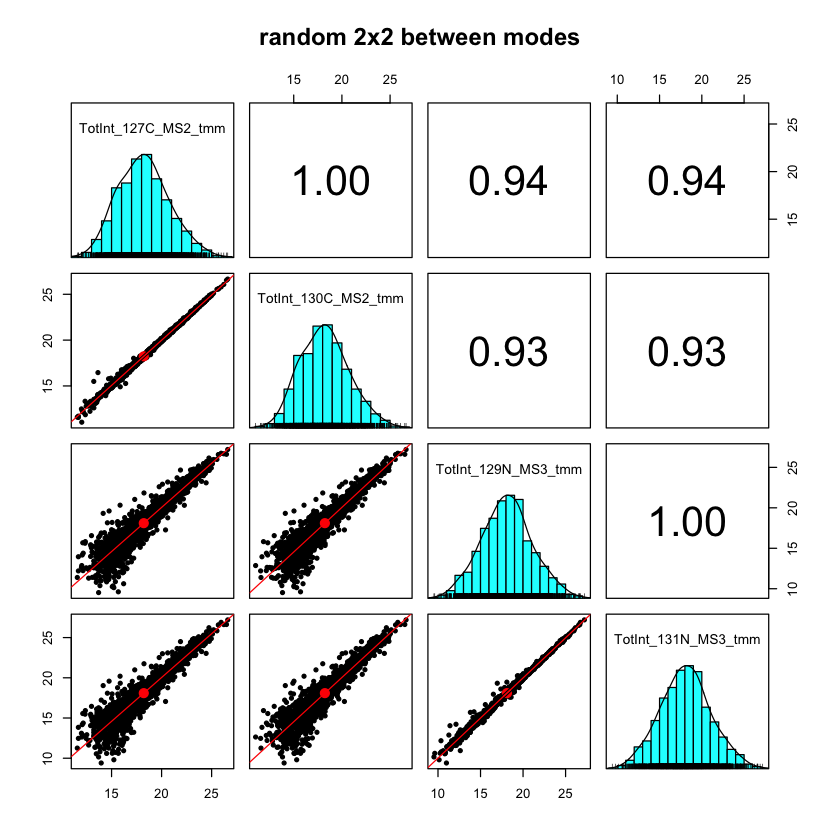

In [11]:
# multi-panel scatter plot grids
left <- sample(1:10, 2)
right <- sample(11:20, 2)
pairs.panels(log2(data_tmm[c(left, right)]), lm = TRUE, main = "random 2x2 between modes")

## Sampling in shotgun experiments has implications

We see that the data between MS2 and MS3 methods are not well correlated compared to within method data. The precision in isobaric labeling is because the reporter ion measurements come from the same instrument scan. Data aggregation of PSMs to proteins preserves the precision within a given TMT experiment. When we are comparing data from different sets of scans (MS2 versus MS3), we lose the inherent precision. Keep in mind that the scatter plots in the 4 lower left panels are still of the exact same E. coli digests. We could probably fix the differences between the MS2 and MS3 data with some sort of a batch correction method (mock IRS based on averages). The data in the above plot has already been adjusted by very good conventional normalization methods. Taking logarithms and median scaling will **do nothing** to improve the situation. Only a solid understanding of the nature of the data measurements can lead to correct analyses.

---

# Can we put MS2 and MS3 data on a common scale?

The scatter plots above look similar to how pooled channels behave without IRS normalization; namely, within TMT data are "tight", but data between TMT plexes are not very similar. We can use experiment-wide average intensities as mock reference channels and see if we can get the MS2 and MS3 data on a common intensity scale.

The steps:
- normalize grand totals within each plex
- compute plex-wide average intensity vectors
- compute geometric mean vector
- compute scaling vectors for each plex
- apply scaling factors to all channels in each plex

In [12]:
#================= sample loading normalization ================================
SL_Norm <- function(df, color = NULL, plot = TRUE) {
    # This makes each channel sum to the average grand total
        # df - data frame of TMT intensities
        # returns a new data frame with normalized values
    
    # compute scaling factors to make colsums match the average sum
    norm_facs <- mean(c(colSums(df))) / colSums(df)
    cat("SL Factors:\n", sprintf("%-5s -> %f\n", colnames(df), norm_facs))
    df_sl  <- sweep(df, 2, norm_facs, FUN = "*")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(df_sl), col = color, notch = TRUE, main = "SL Normalized data")
    }
    df_sl
}

# make new data frame with row sums from each frame
sl_ms2 <- SL_Norm(data_ms2, plot = FALSE)
sl_ms3 <- SL_Norm(data_ms3, plot = FALSE)
irs <- tibble(rowSums(sl_ms2), rowSums(sl_ms3))
colnames(irs) <- c("sum_ms2", "sum_ms3")

# get the geometric average intensity for each protein
irs$average <- apply(irs, 1, function(x) exp(mean(log(x))))

# compute the scaling factor vectors
irs$fac_ms2 <- irs$average / irs$sum_ms2
irs$fac_ms3 <- irs$average / irs$sum_ms3


# make new data frame with IRS normalized data
data_irs <- sl_ms2 * irs$fac_ms2
data_irs <- cbind(data_irs, sl_ms3 * irs$fac_ms3)   

SL Factors:
 TotInt_126C_MS2 -> 1.087490
 TotInt_127N_MS2 -> 1.032335
 TotInt_127C_MS2 -> 1.112648
 TotInt_128N_MS2 -> 0.962943
 TotInt_128C_MS2 -> 0.882969
 TotInt_129N_MS2 -> 1.072448
 TotInt_129C_MS2 -> 0.915389
 TotInt_130N_MS2 -> 0.928795
 TotInt_130C_MS2 -> 1.020413
 TotInt_131N_MS2 -> 1.041176
SL Factors:
 TotInt_126C_MS3 -> 1.087601
 TotInt_127N_MS3 -> 1.028325
 TotInt_127C_MS3 -> 1.109073
 TotInt_128N_MS3 -> 0.975038
 TotInt_128C_MS3 -> 0.874664
 TotInt_129N_MS3 -> 1.091843
 TotInt_129C_MS3 -> 0.912357
 TotInt_130N_MS3 -> 0.921334
 TotInt_130C_MS3 -> 1.023199
 TotInt_131N_MS3 -> 1.038546


## Check the IRS normalized data with box and density plots

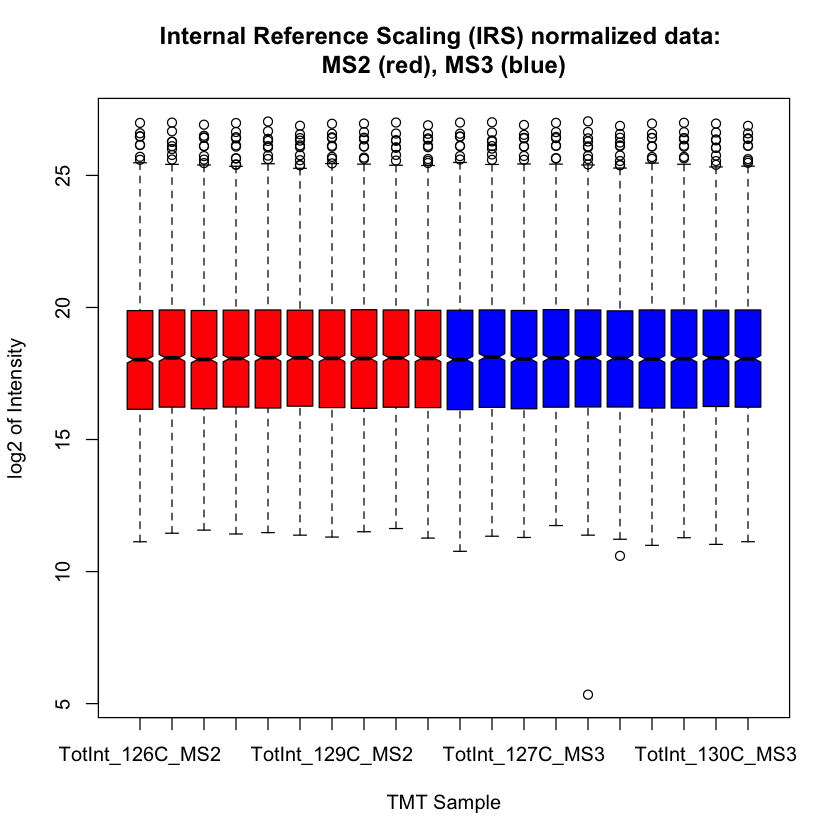

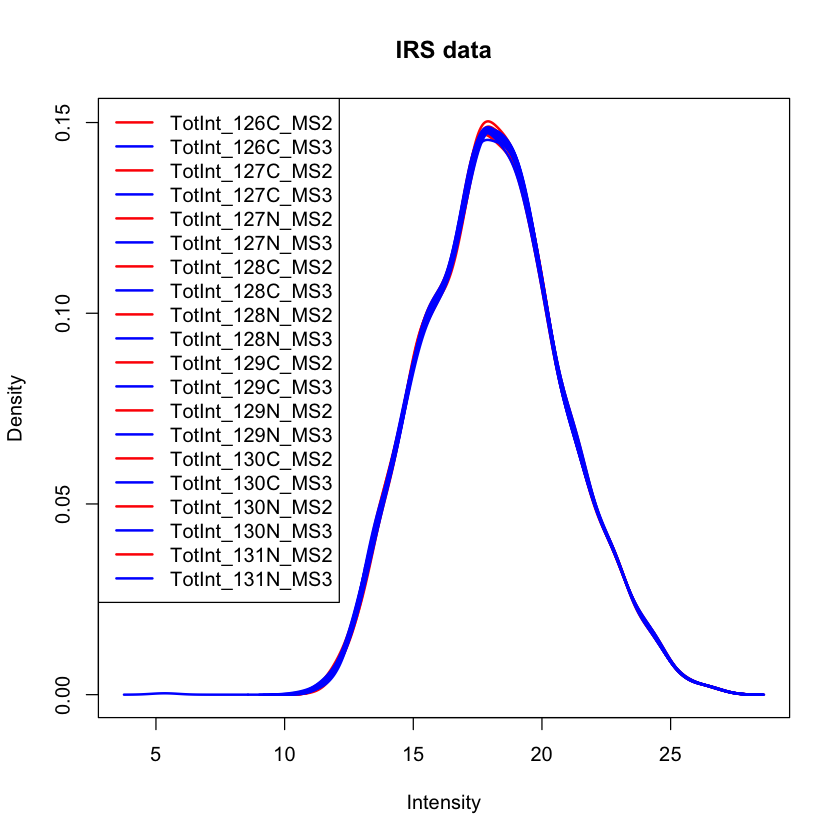

In [13]:
# see what the IRS data look like
boxplot(log2(data_irs), col = rep(c("red", "blue"), each = 10), 
        main = "Internal Reference Scaling (IRS) normalized data: \nMS2 (red), MS3 (blue)",
        xlab = 'TMT Sample', ylab = 'log2 of Intensity', notch = TRUE)

# can also look at density plots (like a distribution histogram)    
plotDensities(log2(data_irs), col = rep(c("red", "blue"), 10), main = "IRS data")

## We can pile on the TMM normalization

The data above look pretty darn good. We can still run the TMM normalization. If the data do not need any further adjustments, the TMM factors will be very minor (very close to 1.0).

We can also see how the samples cluster after we have done the mock-IRS and TMM steps.

Overall Factors (lib.size+TMM):
 TotInt_126C_MS2 -> 1.019214
 TotInt_127N_MS2 -> 1.002235
 TotInt_127C_MS2 -> 1.012916
 TotInt_128N_MS2 -> 0.994158
 TotInt_128C_MS2 -> 1.000582
 TotInt_129N_MS2 -> 0.988537
 TotInt_129C_MS2 -> 0.999255
 TotInt_130N_MS2 -> 1.000317
 TotInt_130C_MS2 -> 0.992678
 TotInt_131N_MS2 -> 0.994765
 TotInt_126C_MS3 -> 1.010531
 TotInt_127N_MS3 -> 1.000079
 TotInt_127C_MS3 -> 1.014105
 TotInt_128N_MS3 -> 0.995720
 TotInt_128C_MS3 -> 0.997579
 TotInt_129N_MS3 -> 0.989050
 TotInt_129C_MS3 -> 1.000899
 TotInt_130N_MS3 -> 1.005107
 TotInt_130C_MS3 -> 0.992784
 TotInt_131N_MS3 -> 0.990198


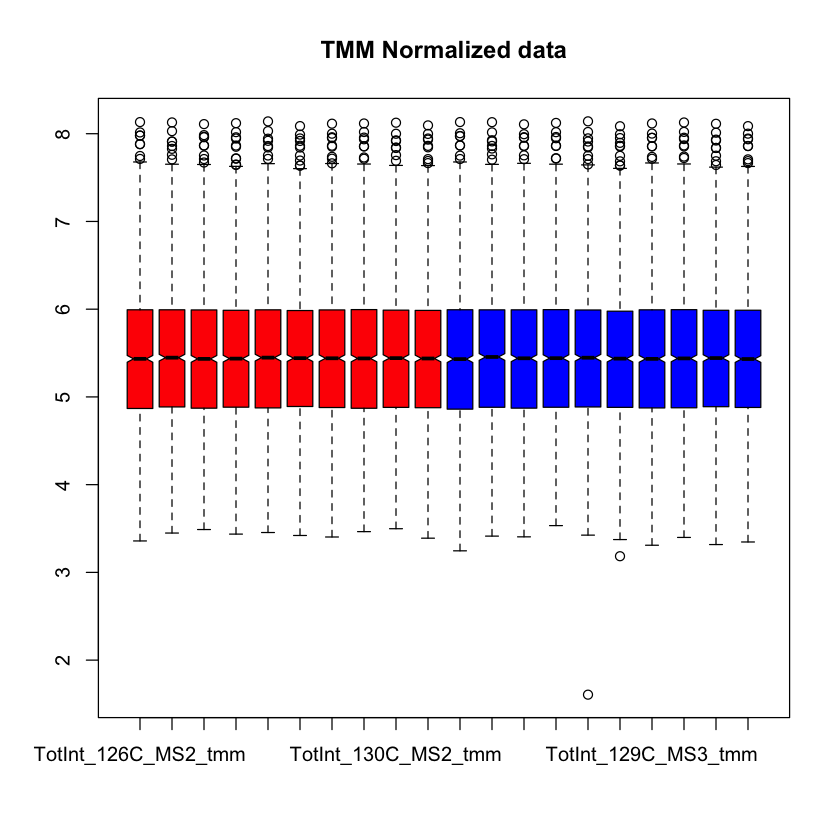

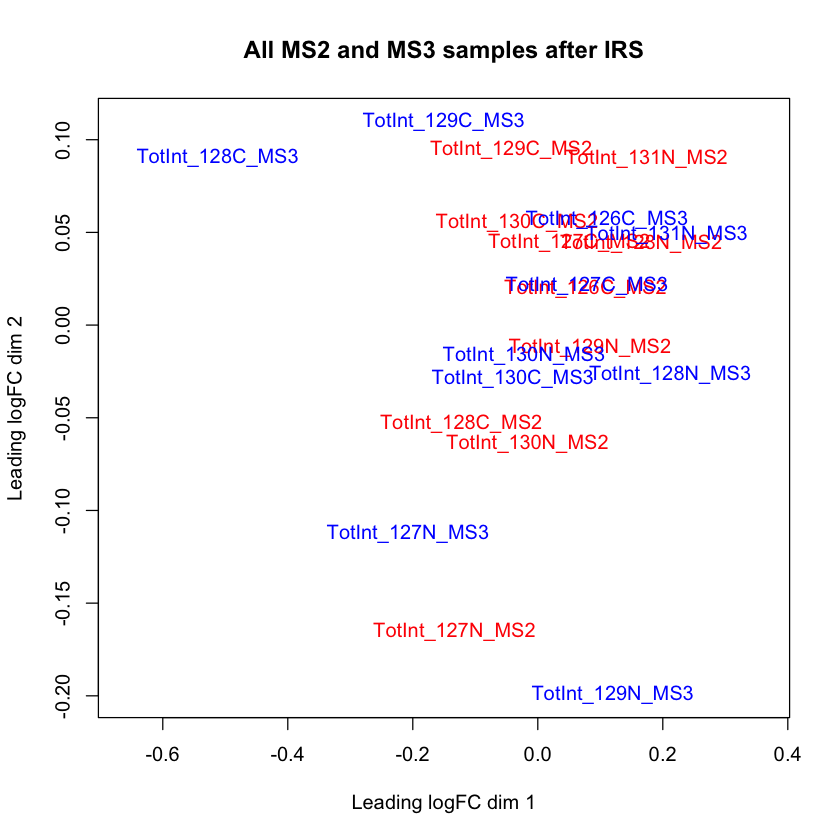

In [14]:
# get the biological sample data into a DGEList object
group = c(rep('MS2', 10), rep('MS3', 10))
y_irs <- DGEList(counts = data_irs, group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y_irs <- calcNormFactors(y_irs)
data_irs_tmm <- apply_tmm_factors(y_irs, colors)

# set some colors by condition
colors = c(rep('red', 10), rep('blue', 10))

# check the clustering
plotMDS(y_irs, col = colors, main = "All MS2 and MS3 samples after IRS")

## The batch-like effect between MS2 and MS3 data is completely gone

CV distributions and median CVs are also useful to check. We will compute those for all 20 channels at the various stages of normalizations.

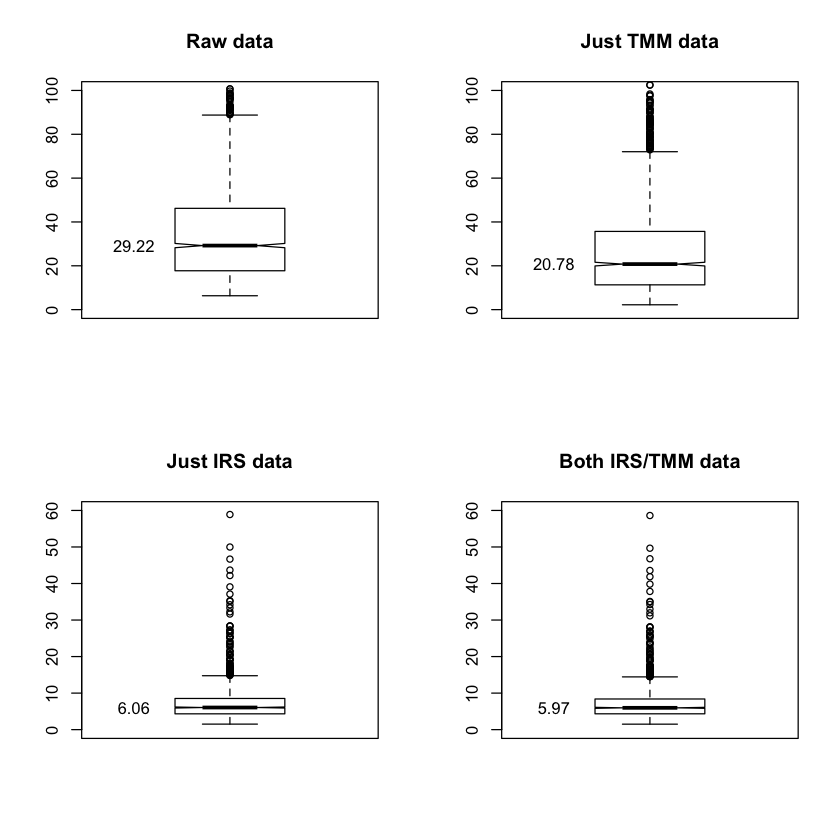

In [15]:
# =========== Boxplot with median label ========================================

labeled_boxplot <- function(df, ylim, title) {
    # Makes a box plot with the median value labeled
        # df - data frame with data to compute CVs of
        # ylim - upper limit for y-axis
        # title - plot title
    cv = CV(df)
    boxplot(cv, ylim = c(0, ylim), notch = TRUE, main = title)
    text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 2))
}

par(mfrow = c(2,2))
labeled_boxplot(cbind(data_ms2, data_ms3), 100, "Raw data")
labeled_boxplot(data_tmm, 100, "Just TMM data")
labeled_boxplot(data_irs, 60, "Just IRS data")
labeled_boxplot(data_irs_tmm, 60, "Both IRS/TMM data")

## Median CVs are impressive after IRS

In the MS2 data (above), we had a median CV of 5.3%. The MS3 data was 6.5%. After the mock-IRS re-scaling, we get 6% median CV across all 20 channels. We can also check the scatter plots.

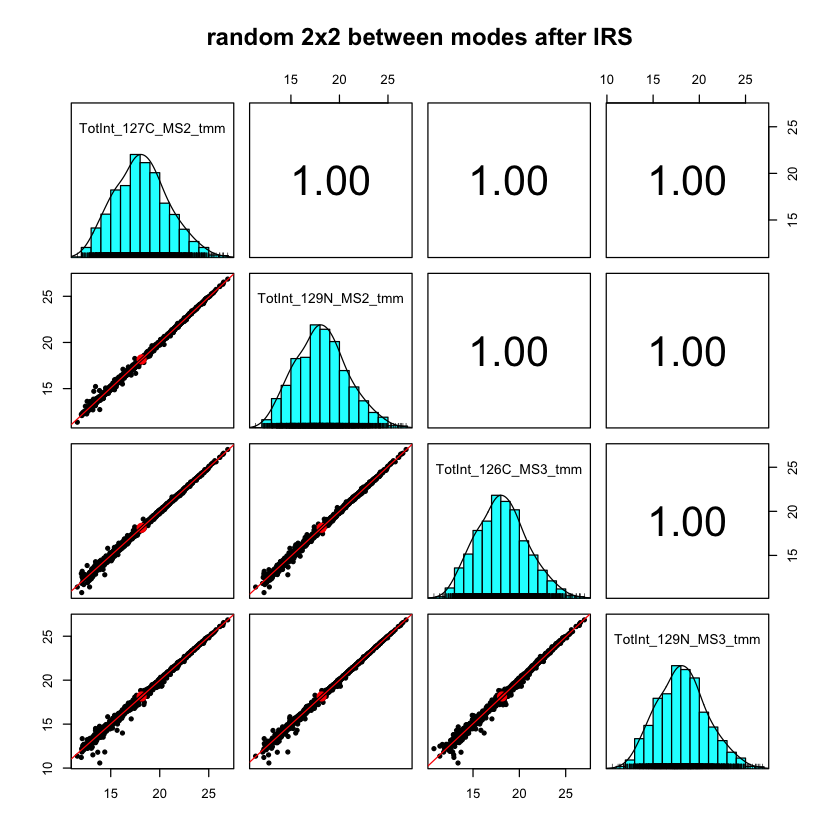

In [16]:
# multi-panel scatter plot grids
left <- sample(1:10, 2)
right <- sample(11:20, 2)
pairs.panels(log2(data_irs_tmm[c(left, right)]), lm = TRUE, main = "random 2x2 between modes after IRS")

---
## Save the TMM normalized data to a TSV file

The mock-IRS was a fun data exercise. We would need to look at more data to see if it really makes any sense to combine reporter ion data acquired with different methods. The data here can be deceptive because we are only looking at proteins that are **not** at different intensities. It is helpful to think of IRS as working on hidden sentinel channels. IRS generates multiplicative factors to make different things that are not supposed to be different be essentially the same. This only applies to the sentinel channels *per se*. The adjusting all of the channels in a plex by those factors only works because of the reporter ions being measured in the same scan. The sentinel channels effectively eavesdrop on all of the channels because of the multiplexed aspect of isobaric tagging. 

In [17]:
write.table(cbind(accessions, data_tmm, irs, data_irs_tmm), "TMM_results.txt", sep = "\t",
           row.names = FALSE, na =  " ")

## Log the session information

In [18]:
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Mojave 10.14.4

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_1.8.12    edgeR_3.24.3    limma_3.38.3    scales_1.0.0   
 [5] forcats_0.4.0   stringr_1.4.0   dplyr_0.8.0.1   purrr_0.3.2    
 [9] readr_1.3.1     tidyr_0.8.3     tibble_2.1.1    ggplot2_3.1.1  
[13] tidyverse_1.2.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.5 locfit_1.5-9.1   repr_0.19.2     
 [5] haven_2.1.0      lattice_0.20-38  colorspace_1.4-1 generics_0.0.2  
 [9] htmltools_0.3.6  base64enc_0.1-3  rlang_0.3.4      pillar_1.3.1    
[13] fo